# creates 51_..._.csv out of the foreground anndata while using leiden and marking the clusters

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path

fg = sc.read_h5ad("00_data/foreground_corrected.h5ad")
fg

AnnData object with n_obs × n_vars = 12315 × 22040
    obs: 'emptydrops_detected', 'fdr_threshold', 'total_umi'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'filtering_info'

In [16]:
# Keep Gene Expression features if available
ft = "Type" if "Type" in fg.var.columns else None
if ft: fg = fg[:, fg.var[ft] == "Gene Expression"].copy()


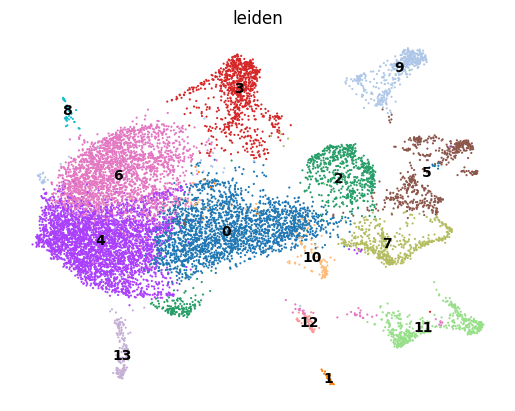

/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name,

In [17]:
# avoid DE issues
sc.pp.filter_genes(fg, min_counts=1)

#  preprocessing pipeline 
sc.pp.normalize_total(fg, target_sum=1e4)
sc.pp.log1p(fg)
sc.pp.highly_variable_genes(fg, n_top_genes=2000, flavor="seurat")
fg = fg[:, fg.var["highly_variable"]].copy()
sc.pp.scale(fg, max_value=10)
sc.tl.pca(fg, n_comps=30, svd_solver="arpack")
sc.pp.neighbors(fg, n_neighbors=20, n_pcs=30)
sc.tl.leiden(fg, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)

sc.tl.umap(fg, min_dist=0.3, spread=1.0, random_state=42)
sc.pl.umap(fg, color=["leiden"], legend_loc="on data", frameon=False, show=True, save="_leiden.png")

sc.tl.rank_genes_groups(fg, "leiden", method="wilcoxon")

In [18]:
sc.tl.rank_genes_groups(fg, groupby="leiden", method="wilcoxon", use_raw=False)
sc.pl.rank_genes_groups(fg, n_genes=25, sharey=False, show=False, save="_top25.png")

/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name,

In [19]:
# Map clusters to cell types by marker scores (edit markers as needed)
marker_sets = {
    "spermatogonia": ["ID4","GFRA1","ZBTB16","UTF1","DMRT1"],
    "spermatocytes": ["SYCP3","SMC1B","REC8","SYCP1"],
    "round_spermatids": ["ACRV1","TNP2","PRM2","CREM"],
    "elongated_spermatids": ["PRM1","TNP1","AKAP4","ODF2"],
    "sertoli": ["SOX9","AMH","FSHR"],
    "leydig": ["CYP17A1","CYP11A1","STAR"],
    "peritubular": ["ACTA2","MYH11","TAGLN"],
}

# Use symbols if present; fallback to IDs
if "Symbol" in fg.var.columns:
    sym = fg.var["Symbol"].astype(str).values
    sym[ (sym=="") | pd.isna(sym) ] = fg.var_names[(sym=="") | pd.isna(sym)]
    fg.var_names = sym
    fg.var_names_make_unique()



In [20]:
# Cluster-level assignment by mean marker expression
ct = pd.Series(index=fg.obs_names, data="unknown")
for cl in fg.obs["leiden"].cat.categories:
    cells = fg.obs_names[fg.obs["leiden"] == cl]
    if len(cells) == 0: continue
    scores = {}
    for name, genes in marker_sets.items():
        g = [g for g in genes if g in fg.var_names]
        if len(g) == 0: scores[name] = -np.inf
        else:
            scores[name] = float(fg[cells, g].X.mean())
    best = max(scores, key=scores.get)
    ct.loc[cells] = best

fg.obs["cluster_type"] = ct.astype("category")



In [ ]:
# Save labels for decontX
out = fg.obs[["cluster_type"]].copy()
out.to_csv("51_foreground_cluster_type_corrected.csv")

# GSEA_new

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(1, '/Users/oskarhaupt/Documents/DE/2024_FU-Bachelor/WS-24-25/Charité/05_sorted/GSEA_new')
from gene_pathway_analysis import SpermatogenesisAnalyzer # main file for GSEA analysis. creates h5ad file with GSEA processed data

/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


Output directory created: 50_2_corrected_foreground/GSEA_20251021_012446
Defined 29 trajectory markers of germ cells (5 categories)
Cell type markers: 62 total including leydig/sertoli etc
Original data shape: (14997, 22040)
Data loaded and QC metrics calculated


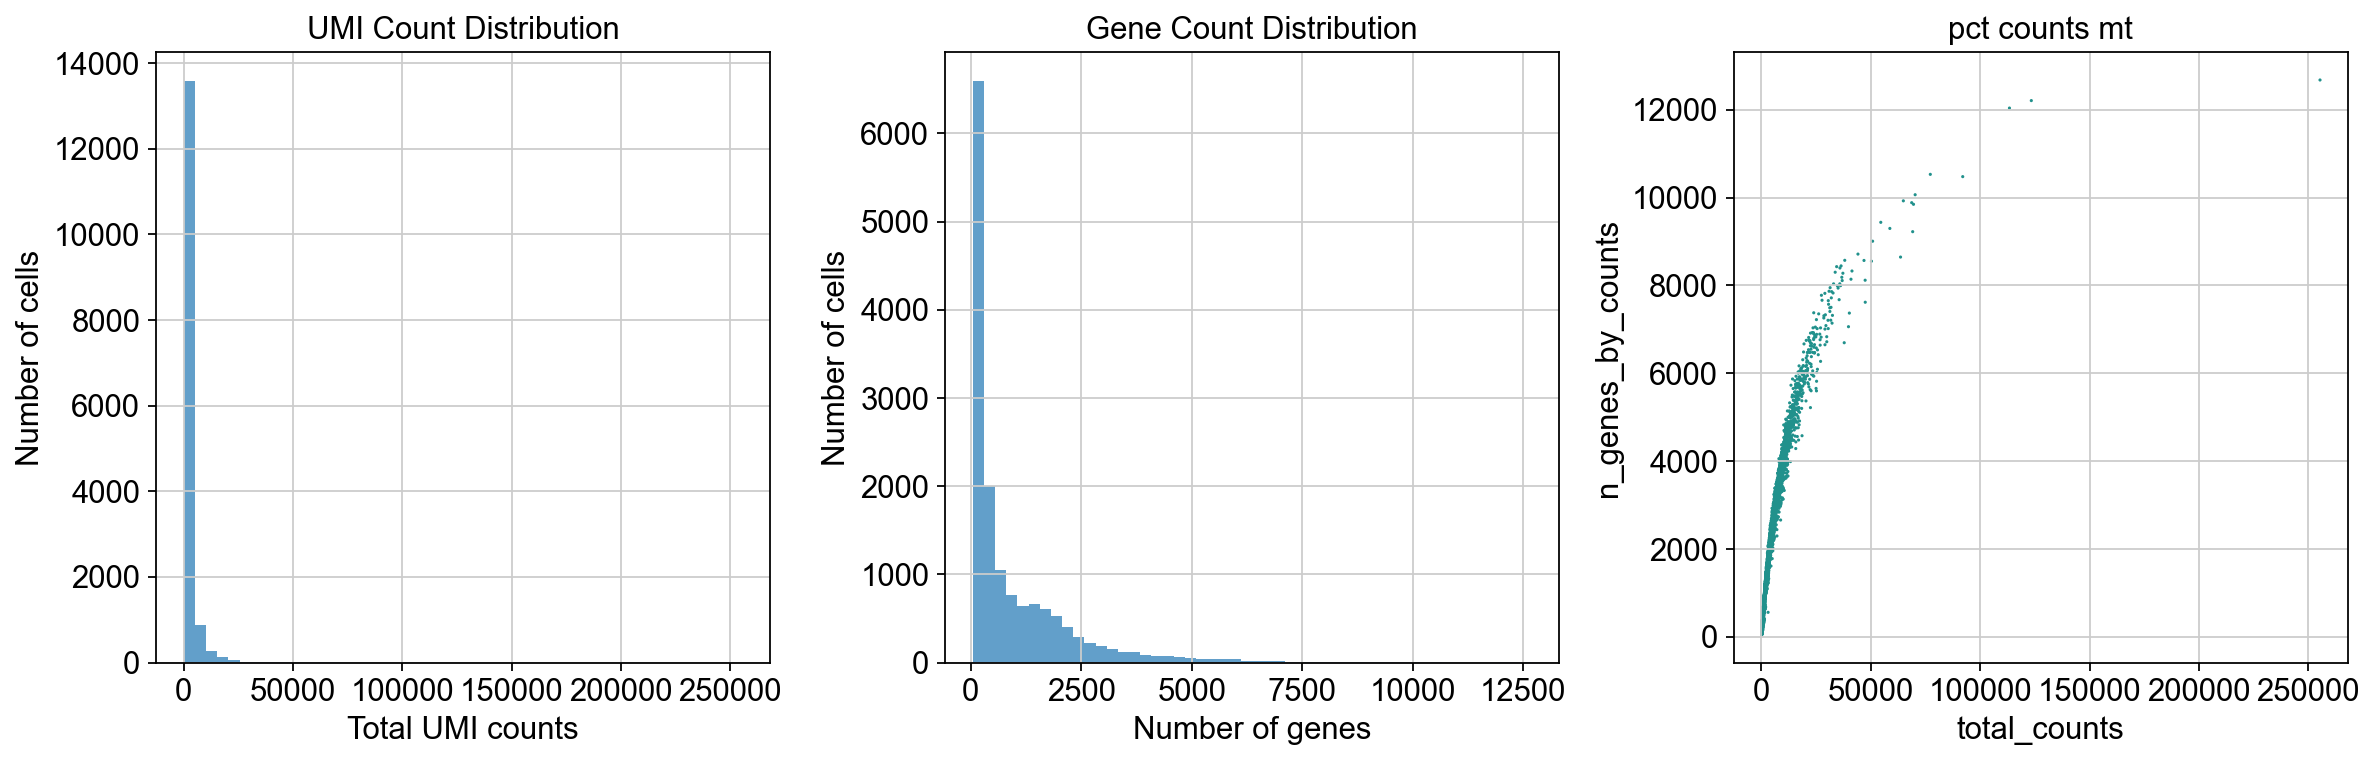


NORMALIZATION & SCALING
Parameters saved to: 50_2_corrected_foreground/GSEA_20251021_012446/parameters.txt
NO custom hvg filter but just for your information:
There would be 6646 highly variable genes available

ADVANCED DIMENSIONALITY REDUCTION


Compute diffusion-based UMAP: 100%|██████████| 4/4 [00:47<00:00, 11.92s/step]



SPERMATOGENESIS TRAJECTORY INFERENCE
Root cluster set: 15

GSEA PATHWAY ANALYSIS
Progression groups: progression_group
LATE     7653
EARLY    7344
Name: count, dtype: int64
(1/1) Running GSEA with GO_Biological_Process_2023...
   -> 2440 pathways found

TOP PATHWAYS (first database):
                                                Term        ES       NES  \
0    Regulation Of Developmental Growth (GO:0048638) -0.769537 -2.649363   
1               Protein Phosphorylation (GO:0006468) -0.533842 -2.615531   
2       Peptidyl-Serine Phosphorylation (GO:0018105) -0.605776 -2.615501   
3  Transmembrane Receptor Protein Tyrosine Kinase... -0.548451 -2.610364   
4          Peptidyl-Serine Modification (GO:0018209) -0.596463 -2.593195   
5  Regulation Of Intracellular Signal Transductio... -0.536218  -2.58619   
6  Cellular Response To Transforming Growth Facto... -0.631145 -2.567596   
7                       Phosphorylation (GO:0016310) -0.531424 -2.567437   
8                   Cytosolic 

In [ ]:

an = SpermatogenesisAnalyzer(data_path='/Users/oskarhaupt/Documents/DE/2024_FU-Bachelor/WS-24-25/Charité/05_sorted/11_decontX/00_data/foreground_corrected.h5ad',
                             output_dir='50_2_corrected_foreground')
adata = an.run_complete_analysis()

# export GSEA_new to csv

In [3]:
cluster_gene_annot = an.adata.obs['cluster_annotation']

In [4]:
# enhanced filtering reduced cells from 12k ED cells to 7493 cells
print(len(cluster_gene_annot)) # 7493 or 12315 probably
print(type(cluster_gene_annot)) # panda series

14997
<class 'pandas.core.series.Series'>


In [5]:
cluster_gene_annot.head()

AAACAGCCAAATATCC-1    elongated_spermatids
AAACAGCCAATTGAGA-1                 Unknown
AAACAGCCACGCAACT-1    elongated_spermatids
AAACAGCCAGTCTAGC-1                 Unknown
AAACAGCCATCAGCAC-1            leydig_cells
Name: cluster_annotation, dtype: category
Categories (5, object): ['Unknown', 'elongated_spermatids', 'leydig_cells', 'round_spermatids', 'spermatocytes']

In [6]:
# Save labels for decontX
cluster_gene_annot.to_csv("51_foreground_cluster_type_corrected.csv")

# create meaningful cluster marker genes
so i iterate over raw gene set and check if the genes are found in the var_names
 -> if not found -> google and check for other names or check if its human only (ex. ARV1/SP-10 as it seems)

In [3]:
gene_marker_list = ['ID4', 'GFRA1', 'ZBTB16', 'NANOS2', 'UTF1', 'SALL4', 'KIT', 
                'DMRT1', 'SOHLH1', 'SOHLH2',
                'STRA8', 'DMRT6', 'SYCP1', 'SYCP2', 'SYCP3', 'HORMAD1', 'HORMAD2', 
                'TEX101', 'MLH1',
                'TNP1', 'TNP2', 
                'PRM1', 'PRM2', 'TNP1', 'TNP2',
                'PRM1', 'PRM2', 'AKAP4', 'SPAG6', 'ARCV1', 'GSTM3', 'CRISP2', 'OAZ3', 'SPATA16'
]
raw = sc.read_10x_h5("00_data/raw.h5")

# iterate over gene_marker_list and check if it is in raw.var_names
for gene in gene_marker_list:
    if gene in raw.var_names:
        print(f"{gene} is in the raw data")
    else:
        print(f"{gene} --- NO")

ausgemusterte_gene = ['ARCV1', 'UTF1', 'SOHLH1', 'DMRT6']

ID4 is in the raw data
GFRA1 is in the raw data
ZBTB16 is in the raw data
NANOS2 is in the raw data
UTF1 --- NO
SALL4 is in the raw data
KIT is in the raw data
DMRT1 is in the raw data
SOHLH1 --- NO
SOHLH2 is in the raw data
STRA8 is in the raw data
DMRT6 --- NO
SYCP1 is in the raw data
SYCP2 is in the raw data
SYCP3 is in the raw data
HORMAD1 is in the raw data
HORMAD2 is in the raw data
TEX101 is in the raw data
MLH1 is in the raw data
TNP1 is in the raw data
TNP2 is in the raw data
PRM1 is in the raw data
PRM2 is in the raw data
TNP1 is in the raw data
TNP2 is in the raw data
PRM1 is in the raw data
PRM2 is in the raw data
AKAP4 is in the raw data
SPAG6 is in the raw data
ARCV1 --- NO
GSTM3 is in the raw data
CRISP2 is in the raw data
OAZ3 is in the raw data
SPATA16 is in the raw data
